In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import Utils.greeks as gr
import Utils.option_pricing_utils as opu

In [20]:
option_exposure = -100000  # Number of options held in portfolio that we want to hedge
S0 = 49
r = 0.05
sigma = 0.2
sigma2 = 0.2 # Realized vol of the path (greater than vol used in BS price - we underestimate)
q = 0
T = 20/52 #20/52
K = 50
type = 'c'

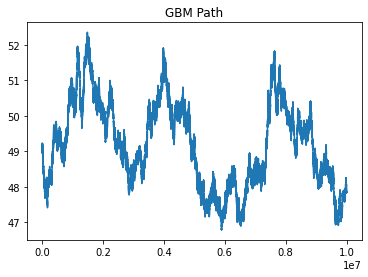

In [21]:
# Geometric Brownian Motion
# dSt = rSt dt + sigma*St dWt
M = 10000000
W = np.random.normal(loc=0.0, scale=1.0, size=M)
T_array = np.linspace(T, 0, M)
dt = T_array[0] - T_array[1]

S = np.zeros(M)
S[0] = S0
for i in range(M-1):
    S[i+1] = S[i] + r*S[i]*dt + sigma2*S[i]*W[i]*np.sqrt(dt)

plt.plot(S)
plt.title('GBM Path')
plt.show()

In [22]:
delta_array = gr.get_delta(S, K, T_array, sigma, r, q, type)
gamma_array = gr.get_gamma(S, K, T_array, sigma, r, q, type)
theta_array = gr.get_theta(S, K, T_array, sigma, r, q, type)

c:\Users\Matthew\Documents\Python Scripts\Option_Pricing\Utils\option_pricing_utils.py:7: RuntimeWarning: divide by zero encountered in true_divide
  d1 = (np.log(S/K) + (r-q+sigma**2/2)*T)/(sigma*np.sqrt(T))
c:\Users\Matthew\Documents\Python Scripts\Option_Pricing\Utils\greeks.py:19: RuntimeWarning: invalid value encountered in true_divide
  return norm.pdf(d1)*np.exp(-q*T)/(S*sigma*np.sqrt(T))
c:\Users\Matthew\Documents\Python Scripts\Option_Pricing\Utils\greeks.py:26: RuntimeWarning: invalid value encountered in true_divide
  theta_call = -r*K*np.exp(-r*T)*norm.cdf(d2) - S*norm.pdf(d1)*sigma*np.exp(-q*T)/(2*np.sqrt(T)) + q*S*norm.cdf(d1)*np.exp(-q*T)


#### Delta Hedging

In [23]:
summary_df = pd.DataFrame(list(zip(S, delta_array, gamma_array, theta_array)), columns=['Stock_Price', 'Delta', 'Gamma', 'Theta'])

In [24]:
summary_df['Shares_Held'] = -option_exposure*delta_array
summary_df['Shares_Purchased'] = -summary_df['Shares_Held'].sub(summary_df['Shares_Held'].shift(-1).fillna(0)).shift().fillna(-summary_df['Shares_Held'])
summary_df['Cost_of_Shares_Purchased'] = summary_df['Shares_Purchased'].mul(summary_df['Stock_Price'])
summary_df['Cumulative_Cost'] = summary_df['Cost_of_Shares_Purchased'].cumsum()
summary_df['Interest_Cost'] = summary_df['Cumulative_Cost']*(r*dt)
summary_df['Cumulative_Cost_Inc_Interest'] =  summary_df['Cumulative_Cost'].add(summary_df['Interest_Cost'].shift()).fillna(summary_df['Cumulative_Cost'])
summary_df['Portfolio_Delta'] = option_exposure*summary_df['Delta'] + summary_df['Shares_Held']*1
summary_df['Portfolio_Gamma'] = option_exposure*summary_df['Gamma'] + summary_df['Shares_Held']*0
summary_df['Portfolio_Theta'] = option_exposure*summary_df['Theta'] + summary_df['Shares_Held']*0

hedging_cost = -K*option_exposure - summary_df['Cumulative_Cost_Inc_Interest'].iloc[-1]  # Cash received for stock - total cost  

print(f'Hedging PnL = ${hedging_cost}')
summary_df

Hedging PnL = $4800153.299451681


,Stock_Price,Delta,Gamma,Theta,Shares_Held,Shares_Purchased,Cost_of_Shares_Purchased,Cumulative_Cost,Interest_Cost,Cumulative_Cost_Inc_Interest,Portfolio_Delta,Portfolio_Gamma,Portfolio_Theta
0,49.000000,0.521605,0.065544,-4.305330,52160.466107,52160.466107,2.555863e+06,2.555863e+06,0.004915,2.555863e+06,0.0,-6554.403935,430532.982293
1,49.002475,0.521767,0.065539,-4.305817,52176.689707,16.223601,7.949966e+02,2.556658e+06,0.004917,2.556658e+06,0.0,-6553.927992,430581.676555
2,49.001521,0.521704,0.065541,-4.305629,52170.430503,-6.259204,-3.067105e+02,2.556351e+06,0.004916,2.556351e+06,0.0,-6554.112173,430562.919769
3,49.000941,0.521666,0.065542,-4.305515,52166.633326,-3.797177,-1.860653e+02,2.556165e+06,0.004916,2.556165e+06,0.0,-6554.223954,430551.544071
4,49.002536,0.521771,0.065539,-4.305829,52177.085109,10.451783,5.121639e+02,2.556677e+06,0.004917,2.556677e+06,0.0,-6553.917308,430582.914208
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9999995,47.854980,0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000e+00,1.998467e+05,0.000384,1.998467e+05,0.0,0.000000,0.000000
9999996,47.854392,0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000e+00,1.998467e+05,0.000384,1.998467e+05,0.0,0.000000,0.000000
9999997,47.852572,0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000e+00,1.998467e+05,0.000384,1.998467e+05,0.0,0.000000,0.000000
9999998,47.852998,0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000e+00,1.998467e+05,0.000384,1.998467e+05,0.0,0.000000,0.000000


In [25]:
profit_df = summary_df[['Stock_Price', 'Interest_Cost', 'Portfolio_Delta', 'Portfolio_Gamma', 'Portfolio_Theta', 'Shares_Held']].copy()
profit_df['Stock_Ret'] = profit_df['Stock_Price'].div(profit_df['Stock_Price'].shift()) - 1
profit_df['Stock_Change'] = profit_df['Stock_Price'].sub(profit_df['Stock_Price'].shift())
profit_df['BS_Option_Price'] = opu.get_bs_price_analytical(S, K, T_array, sigma, r, q, type, display_result=False)
profit_df['Option_Exposure'] = option_exposure*profit_df['BS_Option_Price']
profit_df['Share_Exposure'] = profit_df['Shares_Held'].mul(profit_df['Stock_Price'])
profit_df['Option_PnL'] = -profit_df['Option_Exposure'].shift().sub(profit_df['Option_Exposure'])
profit_df['Share_PnL'] = profit_df['Share_Exposure'].mul(profit_df['Stock_Ret'].shift(-1)).shift()
profit_df['Portfolio_PnL'] = profit_df['Share_PnL'].add(profit_df['Option_PnL'])
profit_df['Projected_Portfolio_Pnl_Delta'] = profit_df['Portfolio_Delta'].shift().mul(profit_df['Stock_Change'])
profit_df['Projected_Portfolio_Pnl_Delta_Gamma'] = profit_df['Portfolio_Delta'].shift().mul(profit_df['Stock_Change']) + 1/2*profit_df['Portfolio_Gamma'].shift().mul(profit_df['Stock_Change']**2)
profit_df['Projected_Portfolio_Pnl_Delta_Gamma_Theta'] = profit_df['Portfolio_Theta'].shift().mul(dt) + profit_df['Portfolio_Delta'].shift().mul(profit_df['Stock_Change']) + 1/2*profit_df['Portfolio_Gamma'].shift().mul(profit_df['Stock_Change']**2)
profit_df['Projected_Portfolio_Pnl_Delta_Theta'] = profit_df['Portfolio_Theta'].shift().mul(dt) + profit_df['Portfolio_Delta'].shift().mul(profit_df['Stock_Change'])
profit_df['Projected_Portfolio_Pnl_Delta_Gamma_Theta_Interest'] = profit_df['Portfolio_Theta'].shift().mul(dt) + profit_df['Portfolio_Delta'].shift().mul(profit_df['Stock_Change']) + 1/2*profit_df['Portfolio_Gamma'].shift().mul(profit_df['Stock_Change']**2) - profit_df['Interest_Cost']

profit_df = profit_df.astype(float).round(4)
profit_df

c:\Users\Matthew\Documents\Python Scripts\Option_Pricing\Utils\option_pricing_utils.py:7: RuntimeWarning: divide by zero encountered in true_divide
  d1 = (np.log(S/K) + (r-q+sigma**2/2)*T)/(sigma*np.sqrt(T))


,Stock_Price,Interest_Cost,Portfolio_Delta,Portfolio_Gamma,Portfolio_Theta,Shares_Held,Stock_Ret,Stock_Change,BS_Option_Price,Option_Exposure,Share_Exposure,Option_PnL,Share_PnL,Portfolio_PnL,Projected_Portfolio_Pnl_Delta,Projected_Portfolio_Pnl_Delta_Gamma,Projected_Portfolio_Pnl_Delta_Gamma_Theta,Projected_Portfolio_Pnl_Delta_Theta,Projected_Portfolio_Pnl_Delta_Gamma_Theta_Interest
0,49.0000,0.0049,0.0,-6554.4039,430532.9823,52160.4661,NaN,NaN,2.4005,-240052.7323,2.555863e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,49.0025,0.0049,0.0,-6553.9280,430581.6766,52176.6897,0.0001,0.0025,2.4018,-240181.8553,2.556787e+06,-129.1229,129.1194,-0.0035,0.0,-0.0201,-0.0035,0.0166,-0.0084
2,49.0015,0.0049,0.0,-6554.1122,430562.9198,52170.4305,-0.0000,-0.0010,2.4013,-240132.0180,2.556430e+06,49.8372,-49.8236,0.0136,-0.0,-0.0030,0.0136,0.0166,0.0087
3,49.0009,0.0049,0.0,-6554.2240,430551.5441,52166.6333,-0.0000,-0.0006,2.4010,-240101.7835,2.556214e+06,30.2345,-30.2191,0.0155,-0.0,-0.0011,0.0155,0.0166,0.0105
4,49.0025,0.0049,0.0,-6553.9173,430582.9142,52177.0851,0.0000,0.0016,2.4018,-240184.9715,2.556809e+06,-83.1880,83.1962,0.0082,0.0,-0.0083,0.0082,0.0166,0.0033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9999995,47.8550,0.0004,0.0,0.0000,0.0000,0.0000,0.0001,0.0025,0.0000,-0.0000,0.000000e+00,-0.0000,0.0000,0.0000,0.0,0.0000,0.0000,0.0000,-0.0004
9999996,47.8544,0.0004,0.0,0.0000,0.0000,0.0000,-0.0000,-0.0006,0.0000,-0.0000,0.000000e+00,-0.0000,-0.0000,-0.0000,-0.0,0.0000,0.0000,0.0000,-0.0004
9999997,47.8526,0.0004,0.0,0.0000,0.0000,0.0000,-0.0000,-0.0018,0.0000,-0.0000,0.000000e+00,-0.0000,-0.0000,-0.0000,-0.0,0.0000,0.0000,0.0000,-0.0004
9999998,47.8530,0.0004,0.0,0.0000,0.0000,0.0000,0.0000,0.0004,0.0000,-0.0000,0.000000e+00,-0.0000,0.0000,0.0000,0.0,0.0000,0.0000,0.0000,-0.0004


In [26]:
print(profit_df['Portfolio_PnL'].sum()) # Actual PnL of the portfolio
print(profit_df['Projected_Portfolio_Pnl_Delta_Gamma'].sum()) # Projected PnL of Delta-Hedged Portfolio Including Delta, Gamma at time t
print(profit_df['Projected_Portfolio_Pnl_Delta_Gamma_Theta'].sum()) # Projected PnL of Delta-Hedged Portfolio Including Delta, Gamma, Theta at time t
print(profit_df['Projected_Portfolio_Pnl_Delta_Gamma_Theta_Interest'].sum()) # Projected PnL of Delta-Hedged Portfolio Including Delta, Gamma, Theta at time t, including borring costs

40205.91879999996
-176238.26380000002
40205.8868
-4204.493199999999


c:\Users\Matthew\anaconda3\envs\myenv3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


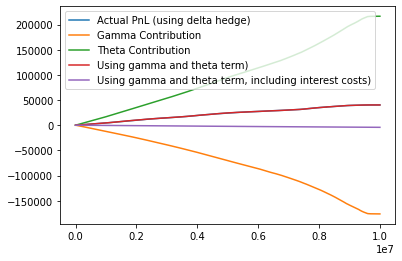

In [27]:
plt.plot(profit_df['Portfolio_PnL'].cumsum(), label='Actual PnL (using delta hedge)')
plt.plot(profit_df['Projected_Portfolio_Pnl_Delta_Gamma'].cumsum(), label='Gamma Contribution')
plt.plot(profit_df['Projected_Portfolio_Pnl_Delta_Theta'].cumsum(), label='Theta Contribution')
plt.plot(profit_df['Projected_Portfolio_Pnl_Delta_Gamma_Theta'].cumsum(), label='Using gamma and theta term)')
plt.plot(profit_df['Projected_Portfolio_Pnl_Delta_Gamma_Theta_Interest'].cumsum(), label='Using gamma and theta term, including interest costs)')

plt.legend()
plt.show()

In [28]:
(profit_df['Projected_Portfolio_Pnl_Delta_Gamma'] - profit_df['Projected_Portfolio_Pnl_Delta_Theta']).max()

-0.0

In [29]:
profit_df['Share_PnL'].sum()

-199846.82100000005

In [30]:
profit_df['Option_PnL'].sum()

240052.7746

In [31]:
profit_df['Interest_Cost'].sum()

44410.99660000002

In [32]:
total_hedging_cost = profit_df['Interest_Cost'].sum() - profit_df['Share_PnL'].sum()
discounted_hedging_cost = np.exp(-r*T)*total_hedging_cost
print(discounted_hedging_cost)

239605.4297543581
